# Desafío III: Prediciendo precios de propiedades

_Autores_: 
* Manuel Alvarez
* Roberto Traber
* Ramiro Savoie

## Planteo del problema
Se nos plantea el problema de desarrollar un tasador automático de propiedades mediante un modelo de regresión basandonos en el dataset de la inmobiliaria Properati.

## Análisis del Dataset

El dataset contiene información referida al primer semestre de 2017 de las propiedades comercializables por la empresa:

* Fecha de creación
* Tipo de la propiedad (house, apartment, ph)
* Operación del aviso (sell, rent)
* Nombre del lugar
* Nombre del lugar + nombre de sus ‘padres’
* ID de geonames del lugar (si está disponible)
* Latitud,Longitud
* Precio original del aviso
* Moneda original del aviso (ARS, USD)
* Precio del aviso en moneda local (ARS)
* Precio aproximado en USD
* Superficie en m²
* Superficie cubierta en m²
* Precio en USD/m²
* Precio por m²
* N° de piso, si corresponde
* Ambientes
* URL en Properati
* Descripción
* Título
* URL de un thumbnail de la primer foto

In [176]:
% matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

# Para eliminar el mensaje de error que sale al ejecutar uno de los comandos.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Cargamos el dataset de Properati.
df = pd.read_csv('data/properatti.csv')

# Información general del dataset.
df.info()

# Variables relevadas.
print(df.columns)

# Muestra de datos.
df.sample(10)

# Principales estadísticos.
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
Unnamed: 0                    121220 non-null int64
operation                     121220 non-null object
property_type                 121220 non-null object
place_name                    121197 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               100810 non-null float64
surface_total_in_m2           81892 non-null float64
surface_covered_in_m2         101313 no

,Unnamed: 0,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,121220.000000,1.025030e+05,69670.000000,69670.000000,1.008100e+05,1.008100e+05,1.008100e+05,81892.000000,101313.000000,68617.000000,8.765800e+04,7899.000000,47390.000000,1.426200e+04
mean,60609.500000,3.574442e+06,-34.626210,-59.266290,4.685259e+05,4.229397e+06,2.397006e+05,233.795328,133.050181,2160.086916,6.912216e+03,17.452336,3.080840,5.009234e+03
std,34993.344153,3.541306e+05,1.980936,2.299922,2.260101e+06,6.904714e+06,3.913239e+05,1782.222147,724.351479,2759.288621,2.837864e+04,120.243621,1.860773,1.204403e+05
min,0.000000,3.427208e+06,-54.823985,-75.678931,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.600000,1.510204e+00,1.000000,1.000000,1.000000e+00
25%,30304.750000,3.430234e+06,-34.669065,-58.727040,1.100000e+05,1.583309e+06,8.973388e+04,50.000000,45.000000,1218.181818,1.550000e+03,1.000000,2.000000,1.000000e+03
50%,60609.500000,3.433910e+06,-34.597985,-58.480128,1.850000e+05,2.558452e+06,1.450000e+05,84.000000,75.000000,1800.000000,2.213115e+03,3.000000,3.000000,2.000000e+03
75%,90914.250000,3.836668e+06,-34.441299,-58.395908,4.200000e+05,4.675792e+06,2.650000e+05,200.000000,150.000000,2486.411765,3.355549e+03,6.000000,4.000000,4.000000e+03
max,121219.000000,6.948895e+06,4.545843,-53.733330,6.500000e+08,8.212711e+08,4.654544e+07,200000.000000,187000.000000,206333.333333,4.000000e+06,3150.000000,32.000000,1.000150e+07


## Corrección del Dataset

In [177]:
# Eliminamos la primera columna dado que el dataframe ya tiene indices enteros.
del(df['Unnamed: 0'])

In [178]:
# Definimos una funcion para chequear los datos faltantes en cada variable.
def check_missing(df):
    print('Datos faltantes en % por cada variable') 
    print(df.isnull().sum(axis=0) / len(df) * 100)
   
check_missing(df)

Datos faltantes en % por cada variable
operation                      0.000000
property_type                  0.000000
place_name                     0.018974
place_with_parent_names        0.000000
country_name                   0.000000
state_name                     0.000000
geonames_id                   15.440521
lat-lon                       42.525986
lat                           42.525986
lon                           42.525986
price                         16.837156
currency                      16.837981
price_aprox_local_currency    16.837156
price_aprox_usd               16.837156
surface_total_in_m2           32.443491
surface_covered_in_m2         16.422208
price_usd_per_m2              43.394654
price_per_m2                  27.686850
floor                         93.483749
rooms                         60.905791
expenses                      88.234615
properati_url                  0.000000
description                    0.001650
title                          0.000000
i

In [179]:
# Corrección de lugares incorrectos.
import re

# Rastreamos las localidades que tengan 3 o más dígitos seguidos y laa establecemos en None para luego corregirlas.
# Por ejemplo place_name = 'coordenadas 34.255511'
def wrong_places(place_name):
    if re.compile('\d{3,}').findall(str(place_name)):
        return None
    else:
        return place_name
    
df['place_name'] = df['place_name'].apply(wrong_places)

# Chequeo de la corrección.
df[df['place_name'] == 'coordenadas 34.255511']

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail


In [180]:
# Incorporamos un nuevo dataframe en el cual ya realizamos la extraccion de nuevos features de la descripción
# y el place_name splitteado.
metadata_df = pd.read_csv('data/properatti-metadata.csv')

# Hacemos un join con ambos dataframes dado que ambos comparten el mismo índice.
df = df.join(metadata_df)

# Eliminamos nuevamente la columna redundante con los indices que agregó el segundo dataframe.
del(df['Unnamed: 0'])

In [181]:
# Completamos los faltantes en la variable place_name con los datos extraídos.
df['place_name'].fillna(value=df['place_name_extracted'], inplace=True)

# Eliminamos las columnas auxiliares que utilizamos en el splitteo.
df = df.drop(['country_name_extracted', 'state_name_extracted', 'place_name_extracted'], axis=1)

In [182]:
# Chequeamos nuevamente las variables faltantes
check_missing(df)

Datos faltantes en % por cada variable
operation                      0.000000
property_type                  0.000000
place_name                     0.000000
place_with_parent_names        0.000000
country_name                   0.000000
state_name                     0.000000
geonames_id                   15.440521
lat-lon                       42.525986
lat                           42.525986
lon                           42.525986
price                         16.837156
currency                      16.837981
price_aprox_local_currency    16.837156
price_aprox_usd               16.837156
surface_total_in_m2           32.443491
surface_covered_in_m2         16.422208
price_usd_per_m2              43.394654
price_per_m2                  27.686850
floor                         93.483749
rooms                         60.905791
expenses                      88.234615
properati_url                  0.000000
description                    0.001650
title                          0.000000
i

In [183]:
# Creamos una pivot table para la media de surface_covered_in_m2 agrupada por place_name y property_type.
flattened_pivot_surface = pd.DataFrame(df.pivot_table(values = 'surface_covered_in_m2', index = ['place_name','property_type'],
                                aggfunc = 'mean').to_records())

In [184]:
# Lo mergeamos con el dataframe original.
cleaned_df = df.merge(flattened_pivot_surface, how='left', on=['place_name','property_type'])

In [185]:
# Imputamos las medias agrupadas y eliminamos las variables redundantes
cleaned_df.surface_covered_in_m2_x.fillna(cleaned_df.surface_covered_in_m2_y, inplace=True)
del cleaned_df['surface_covered_in_m2_y']
cleaned_df['surface_covered_in_m2'] = cleaned_df['surface_covered_in_m2_x']
del cleaned_df['surface_covered_in_m2_x']

In [186]:
# Chequeamos nuevamente las variables faltantes.
check_missing(cleaned_df)

Datos faltantes en % por cada variable
operation                      0.000000
property_type                  0.000000
place_name                     0.000000
place_with_parent_names        0.000000
country_name                   0.000000
state_name                     0.000000
geonames_id                   15.440521
lat-lon                       42.525986
lat                           42.525986
lon                           42.525986
price                         16.837156
currency                      16.837981
price_aprox_local_currency    16.837156
price_aprox_usd               16.837156
surface_total_in_m2           32.443491
price_usd_per_m2              43.394654
price_per_m2                  27.686850
floor                         93.483749
rooms                         60.905791
expenses                      88.234615
properati_url                  0.000000
description                    0.001650
title                          0.000000
image_thumbnail                2.567233
a

## Construcción de nuevos features

In [187]:
# TODO (manu): Acá iria la selección de features que hizo Manu con WordCloud, explicar cuales fueros los criterios.

In [188]:
# Generamos las dummies para property_type
cleaned_df = pd.get_dummies(cleaned_df, columns=['property_type'])

In [189]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121220 entries, 0 to 121219
Data columns (total 43 columns):
operation                     121220 non-null object
place_name                    121220 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               100810 non-null float64
surface_total_in_m2           81892 non-null float64
price_usd_per_m2              68617 non-null float64
price_per_m2                  87658 non-null float64
floor                         7899 non

## Modelo de regresión lineal

### Construcción de un pipeline general para los distinos modelos de regresión

In [214]:
from sklearn import preprocessing

# Definimos una función para filtrar un subconjunto de los datos, basado en los features que son de interés.
def filter_by_features(features, input_df):
    filtered_df = input_df
    features_list = [(key, value) for key, value in features.items()]
    for feature, feature_value in features_list:
        filtered_df = filtered_df[filtered_df[feature] == feature_value]
        
    return filtered_df

# Definimos una funcion para corregir los outliers en los features seleccionados.
def fix_outliers(features_to_fix, input_df):
    fixed_df = input_df
    for feature in features_to_fix:
        fixed_df = fixed_df[((fixed_df[feature] - fixed_df[feature].mean()) / fixed_df[feature].std()).abs() < 2.5]
        
    return fixed_df

# Funcion para normalizar los features seleccionados con un Min-Max.
def normalize_features(features_to_normalize, input_df):
    scaler = preprocessing.MinMaxScaler()
    normalized_df = input_df
    
    for feature in features_to_normalize:
        normalized_df[feature] = scaler.fit_transform(normalized_df[[feature]])
    
    return normalized_df

Seleccionamos Recoleta con las siguientes caracteristicas para un primer análisis.

In [215]:
# Subconjunto del dataset sobre el que queremos hacer el analisis.
features_to_filter = {
    'place_name' : 'Recoleta',
    'property_type_apartment': 1,
    'nuevo': 1,
    'refaccionado': 0
}

# Seleccionamos un barrio con las características dadas.
filtered_df = filter_by_features(features_to_filter, cleaned_df)
print("Cantidad de muestras en el barrio seleccionado:", filtered_df.shape)

Cantidad de muestras en el barrio seleccionado: (143, 43)


In [216]:
# Variable objetivo.
target_feature = ['price_usd_per_m2']

# Seleccion de features para el modelo.
features_selection = ['surface_covered_in_m2', 'property_type_apartment', 'ambients','nuevo','pileta_piscina', 'subte', 'parrilla', 'balcon', 'AC', 'terraza']

# Eliminamos las filas en la que no pudimos imputar datos y construimos un dataframe con todos los datos.
filtered_df = filtered_df[features_selection + target_feature].dropna()
print("Cantidad de muestras luego de eliminar las que no pudimos imputar", filtered_df.shape)

Cantidad de muestras luego de eliminar las que no pudimos imputar (52, 11)


Mapa de calor de correlaciones


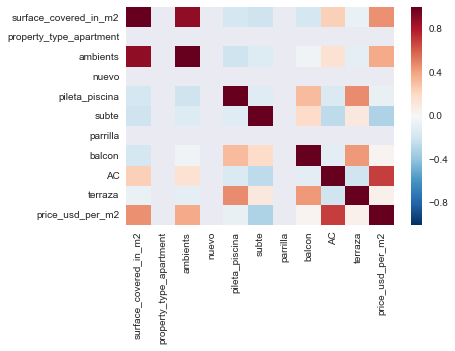

In [217]:
print("Mapa de calor de correlaciones")
sns.heatmap(filtered_df.corr());

Boxplot previo a la correccion de outliers surface_covered_in_m2


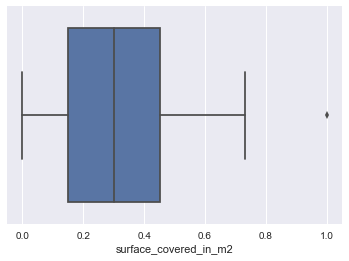

In [224]:
# Detectando outliers.
print("Boxplot previo a la correccion de outliers", 'surface_covered_in_m2')
sns.boxplot(x = 'surface_covered_in_m2', data = filtered_df);

Boxplot luego de corregir outliers surface_covered_in_m2


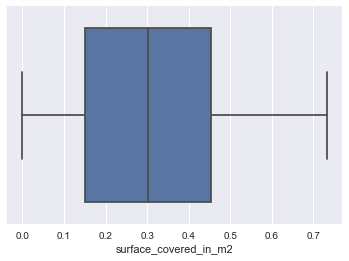

In [225]:
# Features en los que vamos a corregir los outliers.
features_to_fix = ['surface_covered_in_m2', 'price_usd_per_m2', 'ambients']

# Corrigiendo outliers
fixed_df = fix_outliers(features_to_fix, filtered_df)

# Luego de filtrar outliers
print("Boxplot luego de corregir outliers", 'surface_covered_in_m2')
sns.boxplot(x = 'surface_covered_in_m2', data = fixed_df);

In [226]:
# Features que necesitamos normalizar.
features_to_normalize = ['surface_covered_in_m2', 'ambients']

# Normalizando los datos.
normalized_df = normalize_features(features_to_normalize, fixed_df)

# Chequeamos que se hayan normalizado los valores.
normalized_df.sample(10)

,surface_covered_in_m2,property_type_apartment,ambients,nuevo,pileta_piscina,subte,parrilla,balcon,AC,terraza,price_usd_per_m2
100236,0.089202,1,0.00,1,0,0,0,0,0,0,2066.666667
77210,0.544601,1,0.75,1,0,0,0,1,0,0,3416.666667
31255,0.507809,1,0.75,1,0,0,0,0,1,0,3008.620690
28917,0.276995,1,0.50,1,0,1,0,0,0,0,2424.657534
28820,0.544601,1,0.75,1,0,0,0,0,0,0,3583.333333
18023,0.619718,1,1.00,1,0,1,0,1,0,0,2466.216216
60566,0.169014,1,0.25,1,0,0,0,1,1,0,4500.000000
64068,0.098592,1,0.00,1,0,0,0,0,0,0,2636.363636
118675,0.990610,1,1.00,1,0,0,0,0,1,0,4888.888889
55136,0.206573,1,0.25,1,1,0,0,1,0,1,3088.235294


In [227]:
# Definimos una funcion para dejar el dataframe listo para entrenar y predecir
def get_training_df(input_df, features_to_filter, features_selection, target_feature, features_to_fix, features_to_normalize):
    filtered_df = filter_by_features(features_to_filter, input_df)
    filtered_df = filtered_df[features_selection + target_feature].dropna()
    fixed_df = fix_outliers(features_to_fix, filtered_df)
    training_df = normalize_features(features_to_normalize, fixed_df)
    
    return training_df

In [249]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Definimos una funcion para imprimir los parametros del modelo.
def model_parameters(model, X):
    model_parameters = {
        'intercept' : model.intercept_
    }
    
    # Solo para Ridge o LASSO.
    if hasattr(model, 'alpha_'):
        model_parameters['alpha'] = model.alpha_
        
    if model.coef_.ndim == 1:
        # En LASSO los coeficients estan en un array de m x 1
        model_parameters['coeficients'] = dict(zip(X.columns, model.coef_))           
    else:
        # En Lineal y Ridge los coeficientes estan en un array dentro de otro array.
        model_parameters['coeficients'] = dict(zip(X.columns, model.coef_[0]))
    
    print('\nParametros:')
    [print(key, value) for key, value in model_parameters.items()]
    return model_parameters

# Definimos una funcion para imprimir las funciones de pérdida.
def loss_functions(model, X, y, y_test, y_predicted):
    loss_functions = {
        'MAE' :  metrics.mean_absolute_error(y_test, y_predicted),
        'MSE' : metrics.mean_squared_error(y_test, y_predicted),
        'RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_predicted)),
        'Score' : model.score(X, y)
    }
    
    print('\nFunciones de pérdida:')    
    [print(key, value) for key, value in loss_functions.items()]
    return loss_functions

## Modelo de regresión lineal simple

In [250]:
linreg = LinearRegression()
training_df = get_training_df(cleaned_df, features_to_filter, features_selection, target_feature, features_to_fix, features_to_normalize)

# Armamos un primer modelo con los datos anteriores.
X = training_df[features_selection]
y = training_df[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

model = linreg.fit(X_train, y_train)
y_predicted = model.predict(X_test) 

model_parameters(model, X)
loss_functions(model, X, y, y_test, y_predicted);


Parametros:
intercept [ 2342.51742332]
coeficients {'surface_covered_in_m2': 1840.6192447527387, 'property_type_apartment': 4.5474735088646412e-13, 'ambients': -372.15892859673932, 'nuevo': 7.3896444519050419e-13, 'pileta_piscina': 30.780234934752976, 'subte': -170.16767372454237, 'parrilla': 0.0, 'balcon': 465.7340054316511, 'AC': 1186.0374559617362, 'terraza': -37.978453238700716}

Funciones de pérdida:
MAE 618.033766369
MSE 546038.639306
RMSE 738.944273478
Score 0.593200848702


## Modelo de regresión lineal regularizado con Ridge

In [251]:
from sklearn import linear_model
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
rlmcv = linear_model.RidgeCV()

# Ajustamos nuevamente nuestro modelo, esta vez con RidgeCV y el alpha por defecto 1.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

ridge_cv_model = rlmcv.fit(X_train, y_train)
y_predicted = ridge_cv_model.predict(X_test)

model_parameters(ridge_cv_model, X)
loss_functions(ridge_cv_model, X, y, y_test, y_predicted);


Parametros:
intercept [ 2456.43262354]
alpha 1.0
coeficients {'surface_covered_in_m2': 800.55794349283292, 'property_type_apartment': 0.0, 'ambients': 398.21683777983691, 'nuevo': 0.0, 'pileta_piscina': -19.206322376733269, 'subte': -266.09586794701363, 'parrilla': 0.0, 'balcon': 336.67930442536499, 'AC': 1107.020834920995, 'terraza': 59.005168376112465}

Funciones de pérdida:
MAE 600.332961491
MSE 489638.822462
RMSE 699.741968487
Score 0.59906030627


## Comparación de los modelos lineal, regularizado con Ridge y con LASSO

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

from sklearn.model_selection import KFold

# Distintos valores de alpha, rango min, rango max, cantidad de elementos.
al_ridge = np.linspace(0.001, 0.3, 300)
al_lasso = np.linspace(0.1, 0.5, 300)
kf = KFold(n_splits=5, shuffle=True, random_state=12)

# Instanciamos los 3 modelos
lm = LinearRegression()
lmRidgeCV = RidgeCV(alphas=al_ridge, cv=kf, normalize=False)
lmLassoCV = LassoCV(alphas=al_lasso, cv=kf, normalize=False)

# Fiteamos los 3 modelos
lm.fit(X_train, y_train)
lmRidgeCV.fit(X_train, y_train)
lmLassoCV.fit(X_train, y_train)

/home/ramiro/bin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=array([ 0.1    ,  0.10134, ...,  0.49866,  0.5    ]),
    copy_X=True, cv=KFold(n_splits=5, random_state=12, shuffle=True),
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [253]:
print("Regresion lineal")
y_predicted = lm.predict(X_test)
model_parameters(lm, X)
loss_functions(lm, X, y, y_test, y_predicted);

Regresion lineal

Parametros:
intercept [ 2342.51742332]
coeficients {'surface_covered_in_m2': 1840.6192447527387, 'property_type_apartment': 4.5474735088646412e-13, 'ambients': -372.15892859673932, 'nuevo': 7.3896444519050419e-13, 'pileta_piscina': 30.780234934752976, 'subte': -170.16767372454237, 'parrilla': 0.0, 'balcon': 465.7340054316511, 'AC': 1186.0374559617362, 'terraza': -37.978453238700716}

Funciones de pérdida:
MAE 618.033766369
MSE 546038.639306
RMSE 738.944273478
Score 0.593200848702


In [254]:
print("Regresion lineal regularizada con Ridge")
y_predicted = model.predict(X_test)
model_parameters(lmRidgeCV, X)
loss_functions(lmRidgeCV, X, y, y_test, y_predicted);

Regresion lineal regularizada con Ridge

Parametros:
intercept [ 2361.61772718]
alpha 0.3
coeficients {'surface_covered_in_m2': 1142.4237834546673, 'property_type_apartment': 0.0, 'ambients': 208.45139048277949, 'nuevo': 0.0, 'pileta_piscina': 3.8996975232971822, 'subte': -233.74789734199629, 'parrilla': 0.0, 'balcon': 398.53206002505635, 'AC': 1172.3007732124668, 'terraza': 35.494361735652348}

Funciones de pérdida:
MAE 618.033766369
MSE 546038.639306
RMSE 738.944273478
Score 0.601870312482


In [255]:
print("Regresion lineal regularizada con LASSO")
y_predicted = lmLassoCV.predict(X_test)
model_parameters(lmLassoCV, X)
loss_functions(lmLassoCV, X, y, y_test, y_predicted);

Regresion lineal regularizada con LASSO

Parametros:
intercept 2339.22332102
alpha 0.5
coeficients {'surface_covered_in_m2': 1754.9792395707686, 'property_type_apartment': 0.0, 'ambients': -294.30310391298877, 'nuevo': 0.0, 'pileta_piscina': 10.587095572633093, 'subte': -175.98788546904808, 'parrilla': 0.0, 'balcon': 456.88504135614409, 'AC': 1186.6722488066353, 'terraza': -16.172024937172079}

Funciones de pérdida:
MAE 613.636378104
MSE 537841.550437
RMSE 733.376813403
Score 0.595889479379


## Validacion de los modelos

In [256]:
# Testeamos los tres modelos contra con los datos de validacion
y_predicted_lineal = lm.predict(X_test)
y_predicted_ridge = lmRidgeCV.predict(X_test)
y_predicted_lasso = lmLassoCV.predict(X_test)

# Y calculamos el error cuadratico medio de cada uno de ellos
print("MSE lineal", mean_squared_error(y_test, y_predicted_lineal), "\n"
      "MSE Ridge",  mean_squared_error(y_test, y_predicted_ridge), "\n"
      "MSE Lasso",  mean_squared_error(y_test, y_predicted_lasso))

MSE lineal 546038.639306 
MSE Ridge 507181.99836 
MSE Lasso 537841.550437


## Nuevas selecciones de features

In [257]:
# Subconjunto del dataset sobre el que queremos hacer el analisis.
features_to_filter = {
    'place_name' : 'Recoleta',
    'property_type_apartment': 1,
    'nuevo': 1,
    'refaccionado': 0
}

# Seleccion de features para el modelo.
features_selection = ['surface_covered_in_m2', 'property_type_apartment', 'ambients','nuevo','pileta_piscina', 'subte', 'parrilla', 'balcon', 'AC', 'terraza']

# Features en los que vamos a corregir los outliers.
features_to_fix = ['surface_covered_in_m2', 'price_usd_per_m2', 'ambients']

# Features que necesitamos normalizar.
features_to_normalize = ['surface_covered_in_m2', 'ambients']

# Dataframe listo para entrenar y predecir.
training_df = get_training_df(cleaned_df, features_to_filter, features_selection, target_feature, features_to_fix, features_to_normalize)

In [258]:
linreg = LinearRegression()

X = training_df[features_selection]
y = training_df[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

model = linreg.fit(X_train, y_train)
y_predicted = model.predict(X_test) 

model_parameters(model, X)
loss_functions(model, X, y, y_test, y_predicted);


Parametros:
intercept [ 2342.51742332]
coeficients {'surface_covered_in_m2': 1840.6192447527387, 'property_type_apartment': 4.5474735088646412e-13, 'ambients': -372.15892859673932, 'nuevo': 7.3896444519050419e-13, 'pileta_piscina': 30.780234934752976, 'subte': -170.16767372454237, 'parrilla': 0.0, 'balcon': 465.7340054316511, 'AC': 1186.0374559617362, 'terraza': -37.978453238700716}

Funciones de pérdida:
MAE 618.033766369
MSE 546038.639306
RMSE 738.944273478
Score 0.593200848702
